In [1]:
from __future__ import annotations

import torch


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from matplotlib.axes._axes import Axes
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from src.base import *
from src.base.distribution import *
from src.base.gt import *

In [3]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])
    
    # Determine color normalization based on the 99th percentile
    cmax = float(np.percentile(H, percentile))
    cmin = 0.0
    norm = Normalize(vmax=cmax, vmin=cmin)
    
    # Plot using imshow for more control
    extent = (xedges[0], xedges[-1], yedges[0], yedges[-1])
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu().numpy(), y=samples[:,1].cpu().numpy(), ax=ax, **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    log_density = density.log_prob(xy).reshape(bins, bins).T
    im = ax.imshow(log_density.cpu().numpy(), extent=(x_min, x_max, y_min, y_max), origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    log_density = density.log_prob(xy).reshape(bins, bins).T
    im = ax.contour(log_density.cpu(), origin='lower', **kwargs)

part 1

In [4]:
# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}

/home/zgdwsl/Projects/flow_matching/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


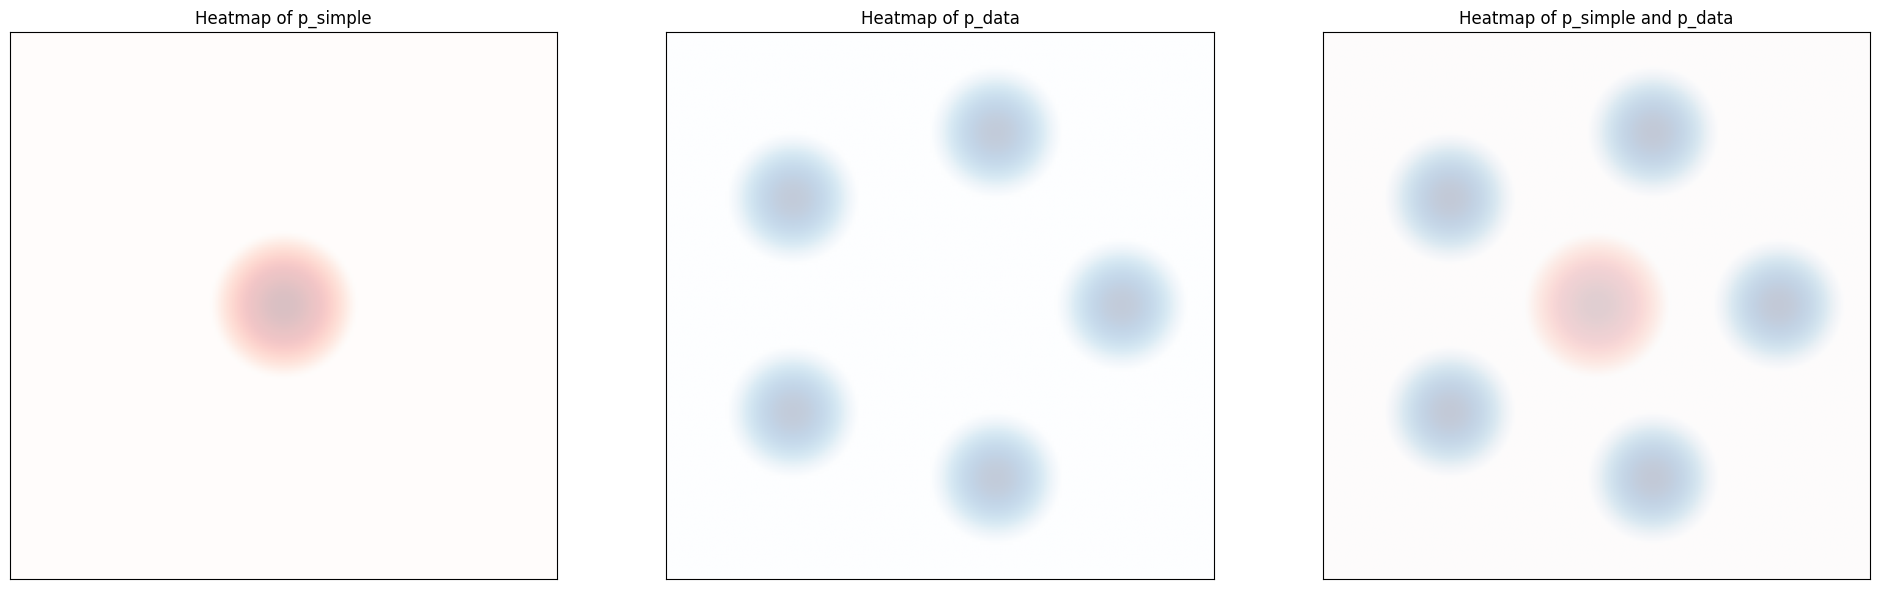

In [5]:
from src.base.distribution import Gaussian, GaussianMixture, Density, Sampleable
p_simple = Gaussian.isotropic(dim=2, std=1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

fig, axes = plt.subplots(1,3, figsize=(24,8))
bins = 200

scale = PARAMS["scale"]
x_bounds = (-scale,scale)
y_bounds = (-scale,scale)

axes[0].set_title('Heatmap of p_simple')
axes[0].set_xticks([])
axes[0].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[0], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))


axes[1].set_title('Heatmap of p_data')
axes[1].set_xticks([])
axes[1].set_yticks([])
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[1], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

axes[2].set_title('Heatmap of p_simple and p_data')
axes[2].set_xticks([])
axes[2].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

In [6]:
from src.models.conditional import *

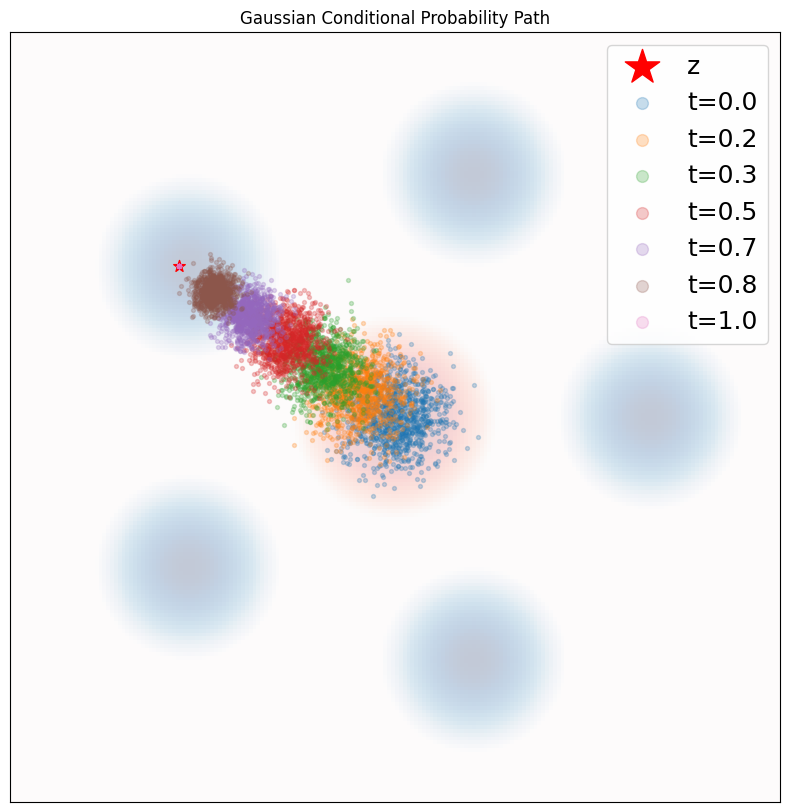

In [7]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

scale = PARAMS["scale"]
x_bounds = (-scale,scale)
y_bounds = (-scale,scale)

plt.figure(figsize=(10,10))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)
plt.title('Gaussian Conditional Probability Path')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

# Sample conditioning variable z
z = path.sample_conditioning_variable(1) # (1,2)
ts = torch.linspace(0.0, 1.0, 7).to(device)

# Plot z
plt.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=75, label='z')
plt.xticks([])
plt.yticks([])

# Plot conditional probability path at each intermediate t
num_samples = 1000
for t in ts:
    zz = z.expand(num_samples, 2)
    tt = t.unsqueeze(0).expand(num_samples, 1) # (samples, 1)
    samples = path.sample_conditional_path(zz, tt) # (samples, 2)
    plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), alpha=0.25, s=8, label=f't={t.item():.1f}')

plt.legend(prop={'size': 18}, markerscale=3)
plt.show()

100%|██████████| 999/999 [00:00<00:00, 3739.67it/s]


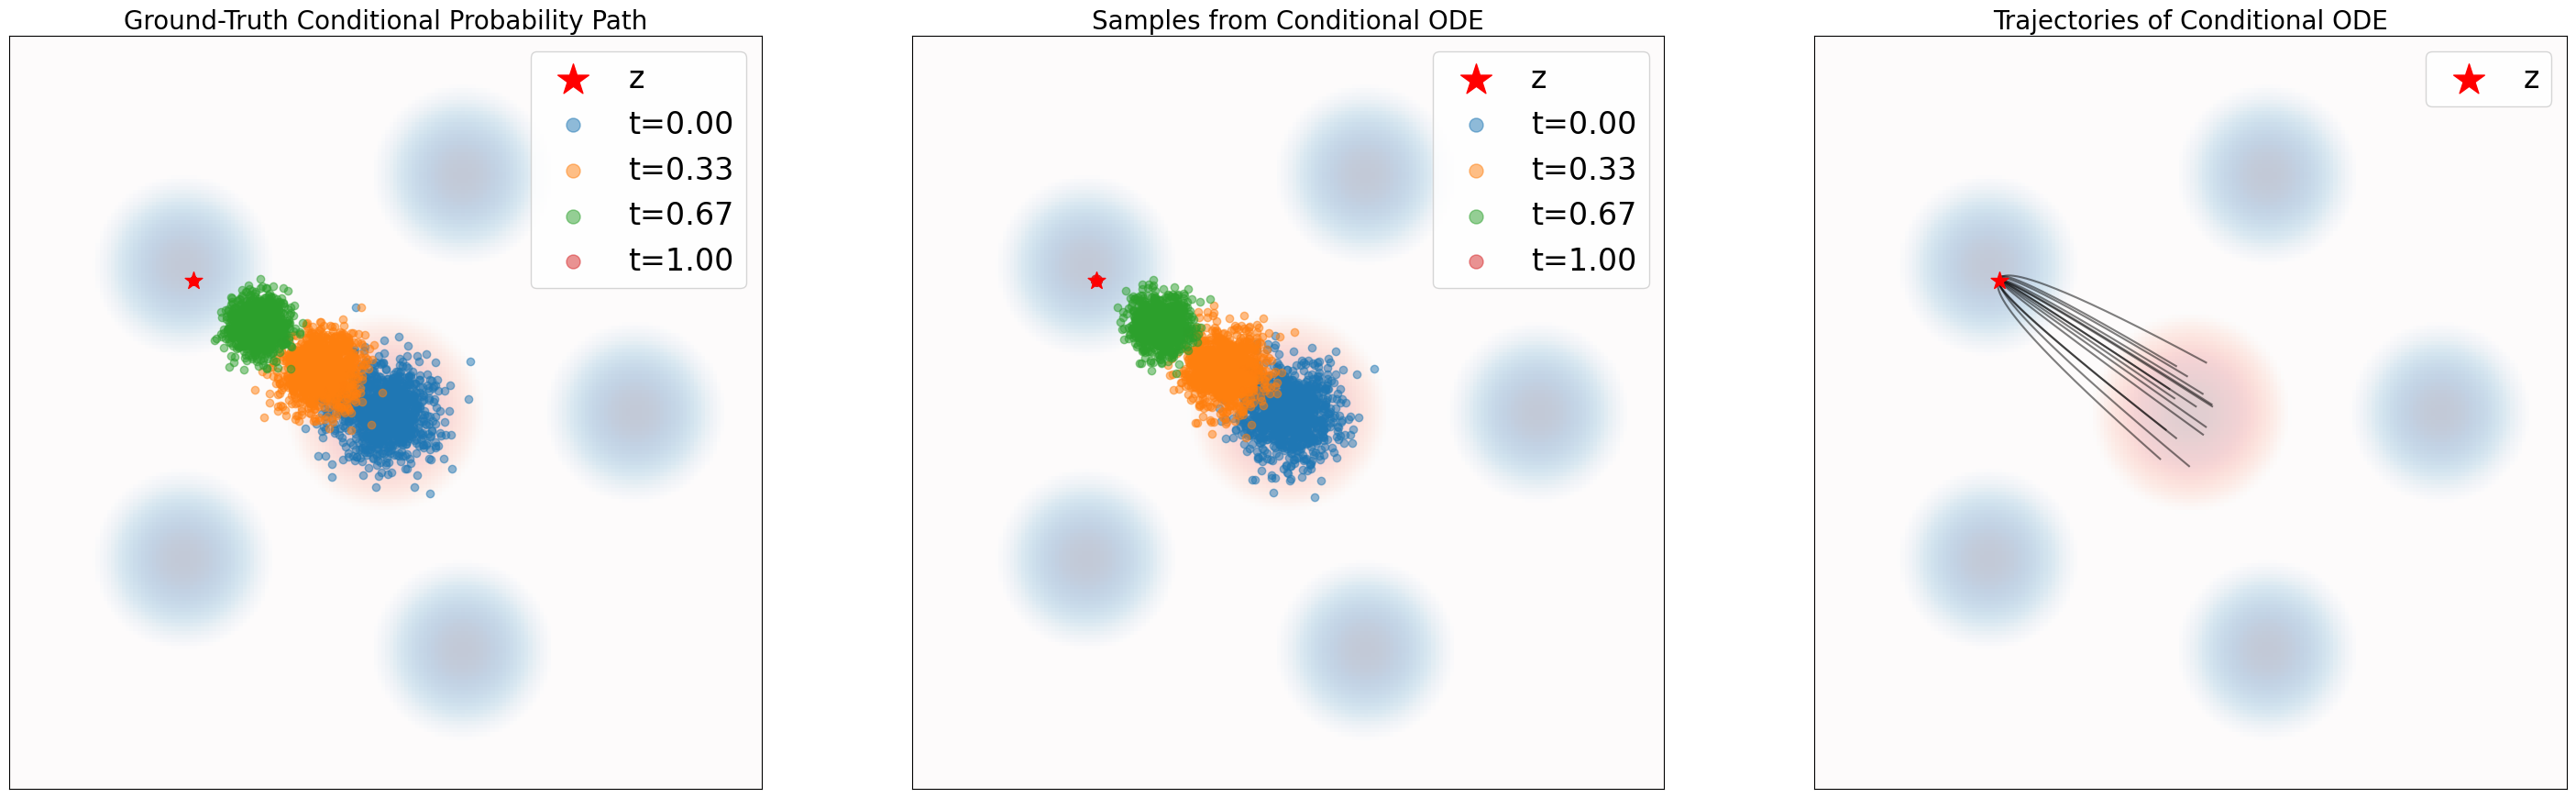

In [8]:
from src.models.conditional import ConditionalVectorFieldODE
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
legend_size = 24
markerscale = 1.8
x_bounds = (-scale,scale)
y_bounds = (-scale,scale)

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph samples from conditional ODE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sigma = 0.5 # Can't make this too high or integration is numerically unstable!
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


#########################################
# Graph Trajectories of Conditional ODE #
#########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(15):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

In [9]:
#3.1
from src.models.conditional import GaussianConditionalProbabilityPath, LinearAlpha, SquareRootBeta
from src.models.model import MLPVectorField, ConditionalFlowMatchingTrainer, LearnedVectorFieldODE


In [10]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

Epoch 4999, loss: 23.9648494720459: : 5000it [00:26, 187.05it/s]  


100%|██████████| 4999/4999 [00:01<00:00, 3405.89it/s]


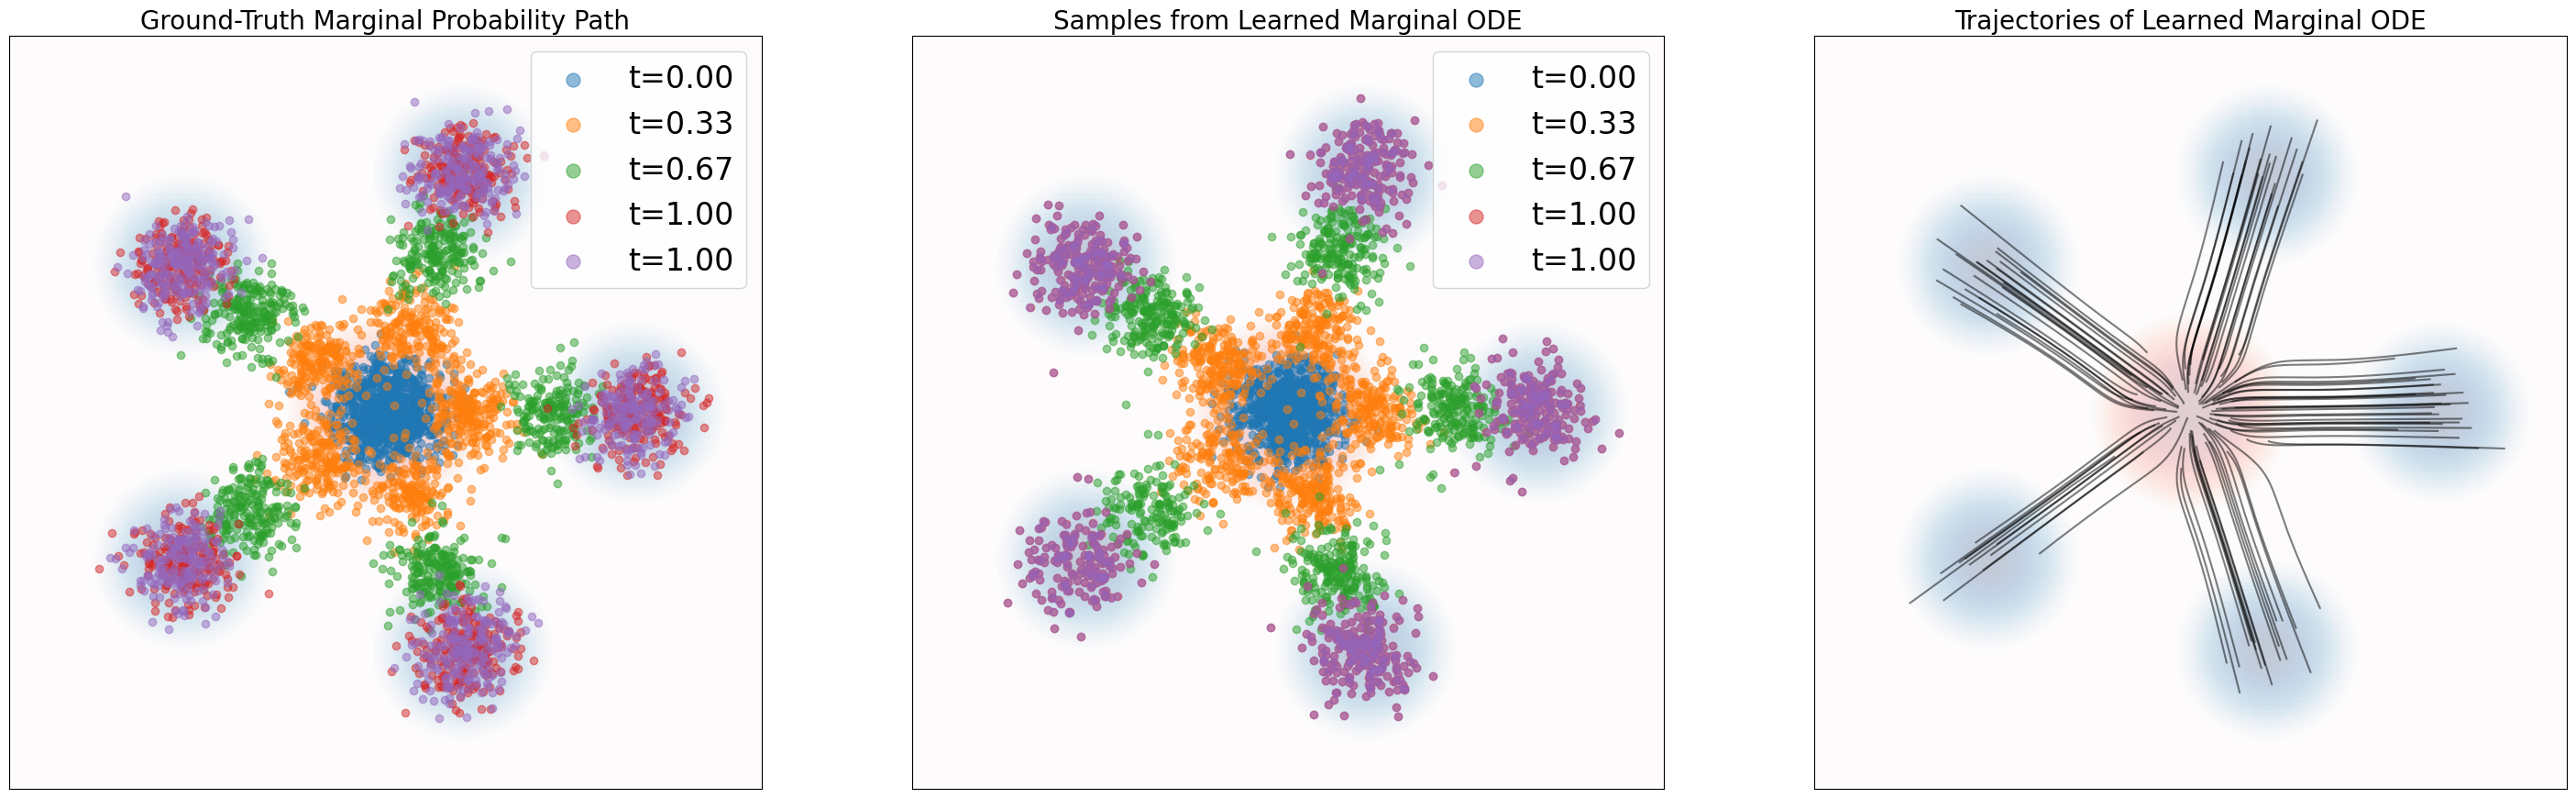

In [11]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 5000
num_marginals = 3


##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = (-scale,scale)
y_bounds = (-scale,scale)
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

################################################
# Graph Ground-Truth Marginal Probability Path #
################################################
ax = axes[0]
ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)
    
plt.show()

In [12]:
#4
class MoonsSampleable(Sampleable):
    """
    Implementation of the Moons distribution using sklearn's make_moons
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale: float = 5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: Standard deviation of Gaussian noise added to the data
            scale: How much to scale the data
            offset: How much to shift the samples from the original distribution (2,)
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: Number of samples to generate
        Returns:
            torch.Tensor: Generated samples with shape (num_samples, 3)
        """
        samples, _ = make_moons(
            n_samples=num_samples,
            noise=self.noise,
            random_state=None  # Allow for random generation each time
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CirclesSampleable(Sampleable):
    """
    Implementation of concentric circle distribution using sklearn's make_circles
    """
    def __init__(self, device: torch.device, noise: float = 0.05, scale=5.0, offset: Optional[torch.Tensor] = None):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.noise = noise
        self.scale = scale
        self.device = device
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        samples, _ = make_circles(
            n_samples=num_samples,
            noise=self.noise,
            factor=0.5,
            random_state=None
        )
        return self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset

class CheckerboardSampleable(Sampleable):
    """
    Checkboard-esque distribution
    """
    def __init__(self, device: torch.device, grid_size: int = 3, scale=5.0):
        """
        Args:
            noise: standard deviation of Gaussian noise added to the data
        """
        self.grid_size = grid_size
        self.scale = scale
        self.device = device

    @property
    def dim(self) -> int:
        return 2

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            num_samples: number of samples to generate
        Returns:
            torch.Tensor: shape (num_samples, 3)
        """
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0,2).to(device)
        while samples.shape[0] < num_samples:
            # Sample num_samples
            new_samples = (torch.rand(num_samples,2).to(self.device) - 0.5) * 2 * self.scale
            x_mask = torch.floor((new_samples[:,0] + self.scale) / grid_length) % 2 == 0 # (bs,)
            y_mask = torch.floor((new_samples[:,1] + self.scale) / grid_length) % 2 == 0 # (bs,)
            accept_mask = torch.logical_xor(~x_mask, y_mask)
            samples = torch.cat([samples, new_samples[accept_mask]], dim=0)
        return samples[:num_samples]

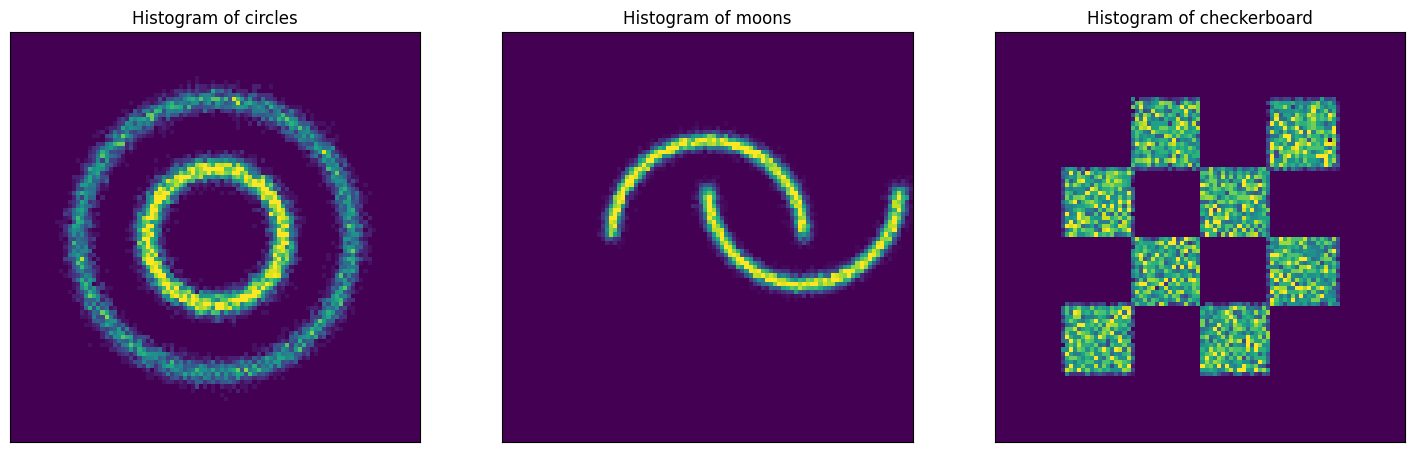

In [13]:
# Visualize alternative choices of p_data
targets = {
    "circles": CirclesSampleable(device),
    "moons": MoonsSampleable(device, scale=3.5),
    "checkerboard": CheckerboardSampleable(device, grid_size=4)
}

###################################
# Graph Various Choices of p_data #
###################################

fig, axes = plt.subplots(1, len(targets), figsize=(6 * len(targets), 6))

num_samples = 20000
num_bins = 100
for idx, (target_name, target) in enumerate(targets.items()):
    ax = axes[idx]
    hist2d_sampleable(target, num_samples, bins=num_bins, scale=7.5, ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Histogram of {target_name}')

plt.show()

In [14]:
#4.1
from src.models.conditional import LinearConditionalProbabilityPath

100%|██████████| 499/499 [00:00<00:00, 1799.67it/s]


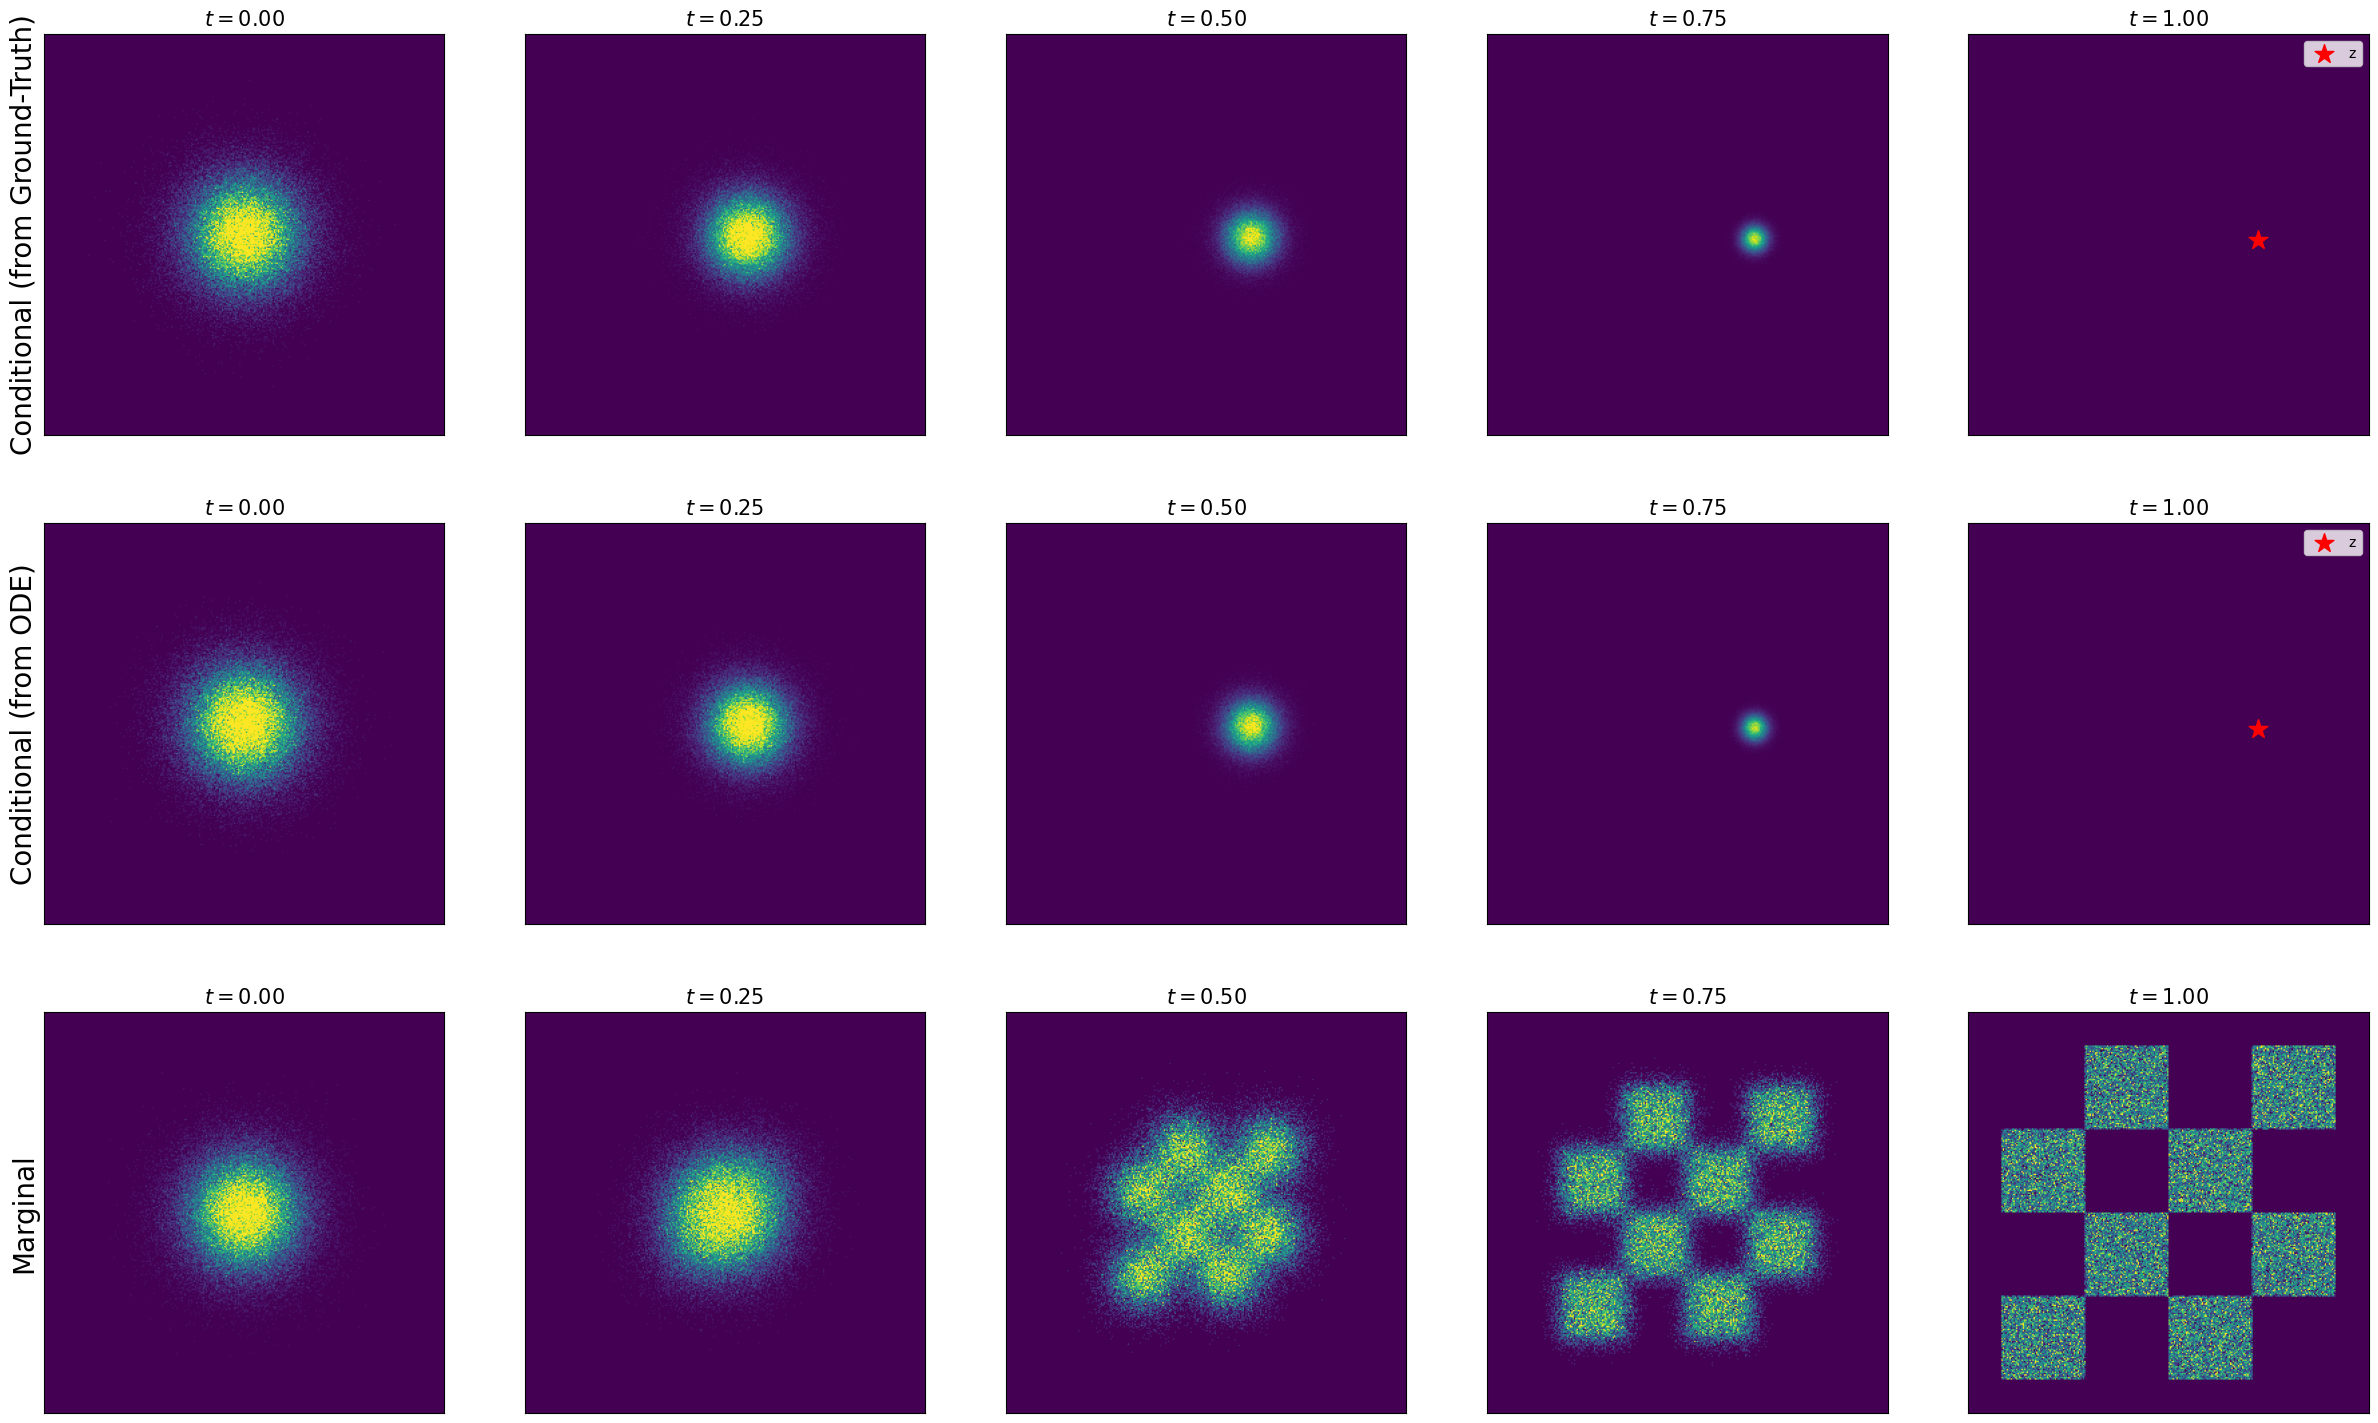

In [15]:
##########################
# Play around with these #
##########################
num_samples = 100000
num_timesteps = 500
num_marginals = 5
assert num_timesteps % (num_marginals - 1) == 0

##########################################
# Construct conditional probability path #
##########################################
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)
z = path.p_data.sample(1) # (1,2)

##############
# Setup plots #
##############

fig, axes = plt.subplots(3, num_marginals, figsize=(6 * num_marginals, 6 * 3))
axes = axes.reshape(3, num_marginals)
scale = 6.0


#####################################################################
# Graph conditional probability paths using sample_conditional_path #
#####################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_conditional_path(zz, tt)
    percentile = min(99 + 2 * torch.sin(t).item(), 100)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Conditional (from Ground-Truth)", fontsize=20)

# Plot z
axes[0,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[0,-1].legend()

######################################################################
# Graph conditional probability paths using conditional_vector_field #
######################################################################
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,num_timesteps).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    tt = ts[record_every_idxs[idx]]
    percentile = min(99 + 2 * torch.sin(tt).item(), 100)
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=300, scale=scale, percentile=percentile, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Conditional (from ODE)", fontsize=20)

# Plot z
axes[1,-1].scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20)
axes[1,-1].legend()

##################################################################
# Graph conditional probability paths using sample_marginal_path #
##################################################################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    zz = z.expand(num_samples, -1)
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[2, idx], bins=300, scale=scale, percentile=99, alpha=1.0)
    axes[2, idx].set_xlim(-scale, scale)
    axes[2, idx].set_ylim(-scale, scale)
    axes[2, idx].set_xticks([])
    axes[2, idx].set_yticks([])
    axes[2, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[2, 0].set_ylabel("Marginal", fontsize=20)

plt.show()

In [16]:
#4.2

In [17]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=2, std=1.0),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model)
losses = trainer.train(num_epochs=10000, device=device, lr=1e-3, batch_size=2000)

Epoch 9999, loss: 8.317595481872559: : 10000it [01:09, 143.32it/s]


100%|██████████| 99/99 [00:00<00:00, 671.60it/s]


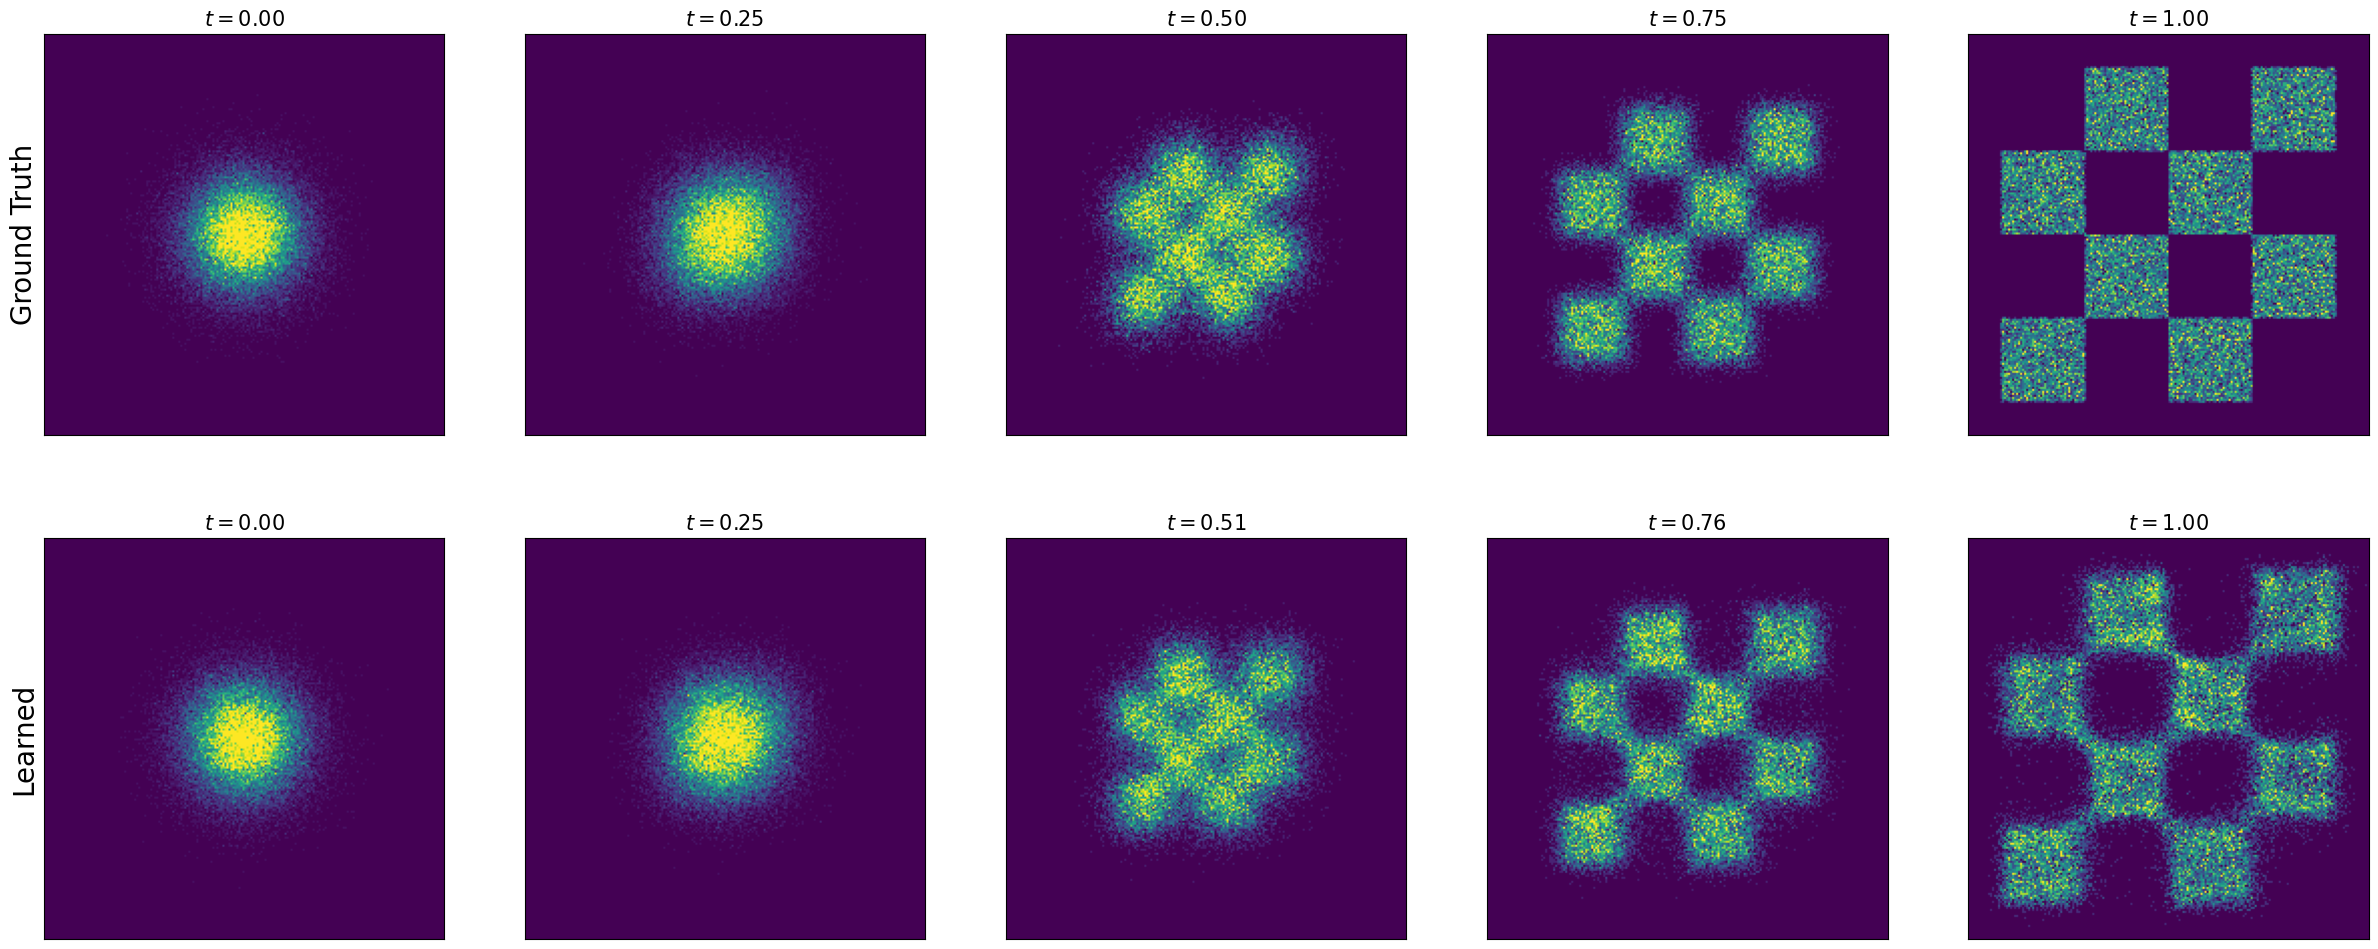

In [18]:
##########################
# Play around With These #
##########################
num_samples = 50000
num_marginals = 5

##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0

###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Marginals of Learned Vector Field #
###############################################
ode = LearnedVectorFieldODE(linear_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,100).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20) 

plt.show()

In [19]:
#4.3

In [20]:
# Construct conditional probability path
path = LinearConditionalProbabilityPath(
    p_simple = CirclesSampleable(device),
    p_data = CheckerboardSampleable(device, grid_size=4)
).to(device)

# Construct learnable vector field
bridging_flow_model = MLPVectorField(dim=2, hiddens=[100,100,100,100])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, bridging_flow_model)
losses = trainer.train(num_epochs=20000, device=device, lr=1e-3, batch_size=2000)

Epoch 19999, loss: 21.517911911010742: : 20000it [02:09, 154.24it/s]


100%|██████████| 199/199 [00:00<00:00, 591.76it/s]


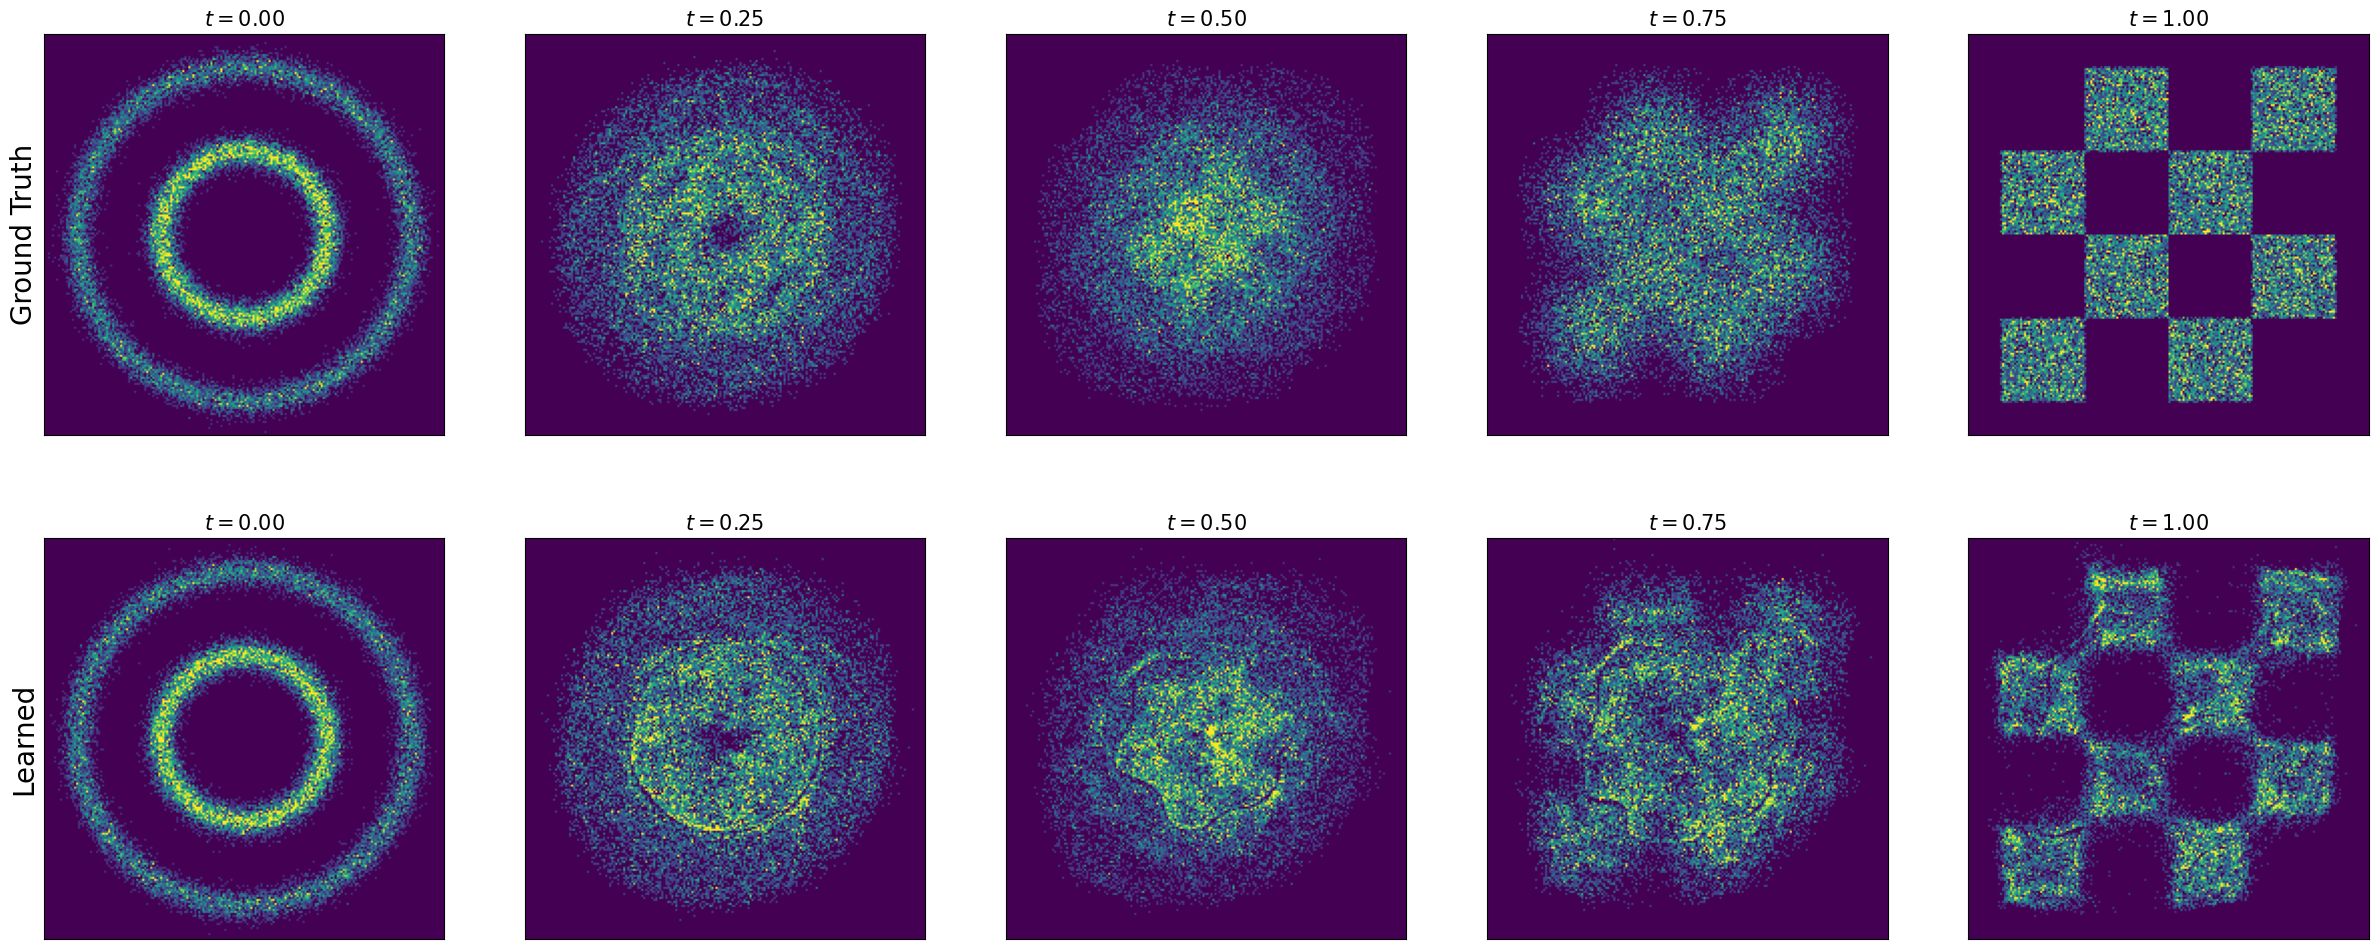

In [21]:
##########################
# Play around With These #
##########################
num_samples = 30000
num_marginals = 5


##############
# Setup Plots #
##############

fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 6 * 2))
axes = axes.reshape(2, num_marginals)
scale = 6.0


###########################
# Graph Ground-Truth Marginals #
###########################
ts = torch.linspace(0.0, 1.0, num_marginals).to(device)
for idx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples,1)
    xts = path.sample_marginal_path(tt)
    hist2d_samples(samples=xts.cpu(), ax=axes[0, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[0, idx].set_xlim(-scale, scale)
    axes[0, idx].set_ylim(-scale, scale)
    axes[0, idx].set_xticks([])
    axes[0, idx].set_yticks([])
    axes[0, idx].set_title(f'$t={t.item():.2f}$', fontsize=15)
axes[0, 0].set_ylabel("Ground Truth", fontsize=20)

###############################################
# Graph Learned Marginals #
###############################################
ode = LearnedVectorFieldODE(bridging_flow_model)
simulator = EulerSimulator(ode)
ts = torch.linspace(0,1,200).to(device)
record_every_idxs = record_every(len(ts), len(ts) // (num_marginals - 1))
x0 = path.p_simple.sample(num_samples)
xts = simulator.simulate_with_trajectory(x0, ts.view(1,-1,1).expand(num_samples,-1,1))
xts = xts[:,record_every_idxs,:]
for idx in range(xts.shape[1]):
    xx = xts[:,idx,:]
    hist2d_samples(samples=xx.cpu(), ax=axes[1, idx], bins=200, scale=scale, percentile=99, alpha=1.0)
    axes[1, idx].set_xlim(-scale, scale)
    axes[1, idx].set_ylim(-scale, scale)
    axes[1, idx].set_xticks([])
    axes[1, idx].set_yticks([])
    tt = ts[record_every_idxs[idx]]
    axes[1, idx].set_title(f'$t={tt.item():.2f}$', fontsize=15)
axes[1, 0].set_ylabel("Learned", fontsize=20)

plt.show()